In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import display
import random
from google.colab import drive
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
import xgboost as xgb
import shap
from sklearn.preprocessing import MinMaxScaler
from sklearn.exceptions import FitFailedWarning
warnings.filterwarnings('ignore', category=FitFailedWarning)


sns.set(font_scale=0.6)

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/2016_LA_merged_scaled_buffer.csv", delimiter=",")
df.head()

,time_index,latitude,longitude,time_obs,temperature,relative_humidity,wind_speed,wind_dir,sid,time_index_dt,...,SAVI_mean_1000m,SAVI_stdDev_1000m,SWIR1_mean_1000m,SWIR1_stdDev_1000m,SWIR2_mean_1000m,SWIR2_stdDev_1000m,Slope_mean_1000m,Slope_stdDev_1000m,Water_dist_mean_1000m,Water_dist_stdDev_1000m
0,2016-06-22 18:00:00,34.281708,-119.212710,2016-06-22 17:35:25,18.88888,78.0,1.34112,227.0,34.281708_-119.21271,2016-06-22 18:00:00,...,0.280450,0.124373,0.269359,0.050461,0.193750,0.043560,5.012306,4.769188,2223.357490,1427.557953
1,2016-06-22 19:00:00,33.770424,-118.150696,2016-06-22 18:38:53,22.77776,74.0,1.78816,196.0,33.770424_-118.150696,2016-06-22 19:00:00,...,0.135314,0.049228,0.198597,0.032042,0.159531,0.024247,1.838091,1.159238,1206.189289,863.879837
2,2016-06-22 19:00:00,34.171330,-118.042500,2016-06-22 18:43:54,30.55557,43.0,0.00000,40.0,34.17133_-118.0425,2016-06-22 19:00:00,...,0.233804,0.046737,0.196802,0.040870,0.140675,0.038861,14.960462,10.913271,10732.669792,3382.888550
3,2016-06-22 19:00:00,34.042170,-118.521170,2016-06-22 18:42:31,21.11110,81.0,0.89408,253.0,34.04217_-118.52117,2016-06-22 19:00:00,...,0.235600,0.085754,0.191932,0.041900,0.140140,0.038668,5.427906,5.050253,2363.242989,1552.830042
4,2016-06-22 19:00:00,35.058390,-119.084160,2016-06-22 18:30:10,33.33334,21.0,0.00000,0.0,35.05839_-119.08416,2016-06-22 19:00:00,...,0.424338,0.157917,0.269627,0.067562,0.177888,0.074911,2.195274,1.293796,395.385324,436.791924


In [ ]:
df.columns[0:30]

Index(['time_index', 'latitude_x', 'longitude_x', 'time_obs', 'temperature',
       'relative_humidity', 'wind_speed', 'wind_dir', 'sid', 'time_index_dt',
       'date', 'longitude_y', 'latitude_y', 'RED', 'GREEN', 'BLUE', 'SWIR1',
       'SWIR2', 'NDVI', 'NDBI', 'NBAI', 'MNDWI', 'EVI', 'SAVI', 'LST',
       'Elevation', 'Water_dist', 'Blue_mean_50m', 'Blue_stdDev_50m',
       'EVI_mean_50m'],
      dtype='object')

In [ ]:
# exlude non-buffered columns and other remnants from original target data
col_exclude = ['time_index', 'latitude', 'longitude', 'time_obs',
       'relative_humidity', 'wind_speed', 'wind_dir', 'sid', 'time_index_dt',
       'date', 'longitude_y', 'latitude_y', 'RED', 'GREEN', 'BLUE', 'SWIR1',
       'SWIR2', 'NDVI', 'NDBI', 'NBAI', 'MNDWI', 'EVI', 'SAVI', 'LST',
       'Elevation', 'Water_dist','dayofyear', 'Slope'] + df.filter(regex='SAVI|SWIR2').columns.tolist()

In [ ]:
X = df.drop(columns=col_exclude+['temperature'])
y = df['temperature']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
def compute_metrics_and_plot(name, y_test, y_pred, params, output_df):
  '''
  runs evaluation metrics given predictions and true data, plots them, and appends values to array
  '''
  # run evaluation metrics
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_test, y_pred)

  print(f'{name} MAE: {mae:.4f}')
  print(f'{name} MSE: {mse:.4f}')
  print(f'{name} RMSE: {rmse:.4f}')
  print(f'{name} R2: {r2:.4f}')

  # plot simple predicted vs real plot
  plt.figure(figsize=(8, 6))
  plt.scatter(y_test, y_pred, alpha=0.5)
  plt.xlabel("Actual Values")
  plt.ylabel("Predicted Values")
  plt.title("Actual vs. Predicted Values")
  plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', lw=2)
  plt.show()

  # save values in df
  output_df.loc[len(output_df)] = [
        {name},
        params,
        mae,
        mse,
        rmse,
        r2
  ]

  return output_df

In [ ]:
def find_params_and_fit_model(name, model, params, output_df):
  '''
  performs RandomSearch for hyperparameter tuning and fits model with best parameters
  '''
  print(f"Computing {name} model:")

  # no params to sample for linear regression
  if name == 'linear':
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)

  # else perform RandomSearch to sample random params and find the best ones
  else:
      random_search = RandomizedSearchCV(
          model,
          param_distributions=params,
          n_iter=100,
          scoring='neg_mean_squared_error',
          cv=5, verbose=1, random_state=42, n_jobs=-1
      )

      random_search.fit(X_train, y_train)

      print("Best parameters from RandomizedSearchCV: ", random_search.best_params_)
      best_model = random_search.best_estimator_
      y_pred = best_model.predict(X_test)


  output_df = compute_metrics_and_plot(name, y_test, y_pred, random_search.best_params_ if name != 'linear' else '-', output_df)
  return output_df, model if name == 'linear' else best_model


In [ ]:
# Define output_df to save values in
output_df = pd.DataFrame(columns=['Model', 'Best Parameters', 'MAE', 'MSE', 'RMSE', 'R2'])

Computing linear model:
linear MAE: 2.2359
linear MSE: 8.3513
linear RMSE: 2.8899
linear R2: 0.7726


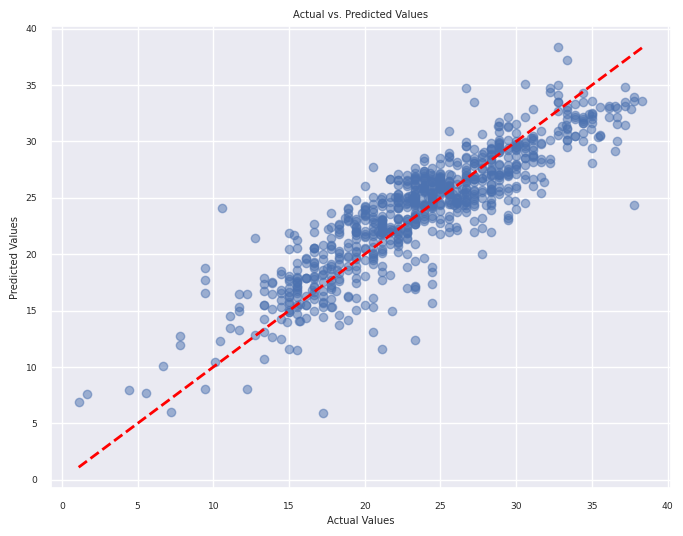

In [ ]:
output_df, model_linear = find_params_and_fit_model('linear', LinearRegression(), None, output_df)

Decision Tree MAE: 1.9305
Decision Tree MSE: 7.1506
Decision Tree RMSE: 2.6741
Decision Tree R2: 0.8053


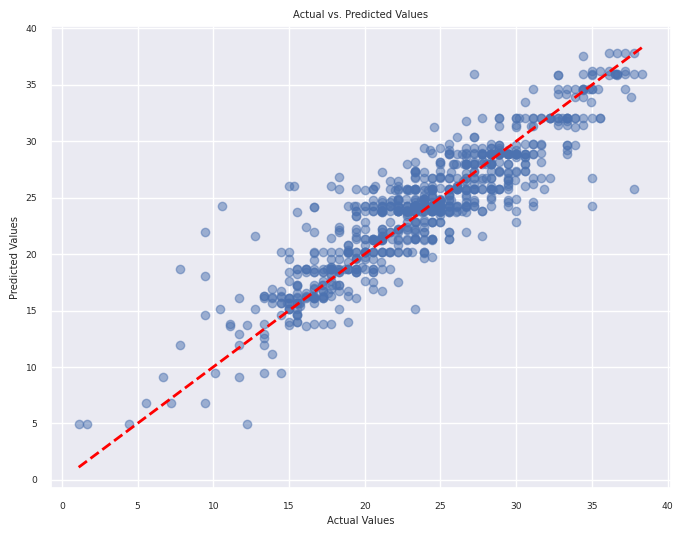

In [ ]:
# output_df, model_dt = find_params_and_fit_model(
#     'Decision Tree',
#     DecisionTreeRegressor(random_state=42),
#     {
#         'criterion': ["squared_error", "friedman_mse"],
#         'splitter': ['best', 'random'],
#         'max_depth': [2, 4, 8, 24, 48, None],
#         'min_samples_split': [2, 5, 10],
#         'min_samples_leaf': [1, 4, 8],
#         'max_features': ['auto', 'sqrt', 'log2', None],

#     },
#     output_df)

# skip hyperparameter tuning, use best model from point-wise
model_dt = DecisionTreeRegressor(splitter='best', min_samples_split=2, min_samples_leaf=8, max_features=None, max_depth=8, criterion='squared_error', random_state=42)
model_dt.fit(X_train, y_train)
y_pred = model_dt.predict(X_test)
output_df = compute_metrics_and_plot('Decision Tree', y_test, y_pred,"{'splitter': 'best', 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': None, 'max_depth': 8, 'criterion': 'squared_error'}", output_df)

XGBoost MAE: 1.2950
XGBoost MSE: 3.4105
XGBoost RMSE: 1.8468
XGBoost R2: 0.9071


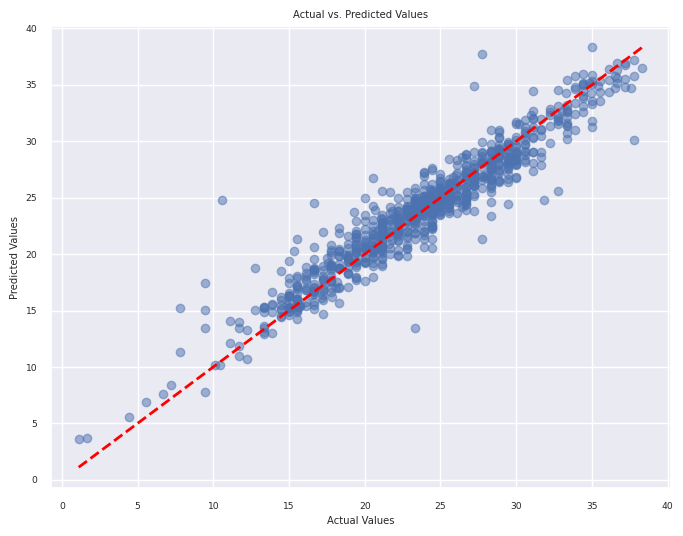

In [ ]:
# ran for too long, used best parameters from non-buffering run isntead
model_xgb = xgb.XGBRegressor(
    subsample=0.75,
    min_child_weight=2,
    max_depth=6,
    gamma=0,
    eta=0.1,
    random_state=42
)
model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_test)

output_df = compute_metrics_and_plot('XGBoost', y_test, y_pred,"{'subsample': 0.75, 'min_child_weight': 2, 'max_depth': 6, 'gamma': 0, 'eta': 0.1}", output_df)

RandomForest MAE: 1.5069
RandomForest MSE: 4.4401
RandomForest RMSE: 2.1072
RandomForest R2: 0.8791


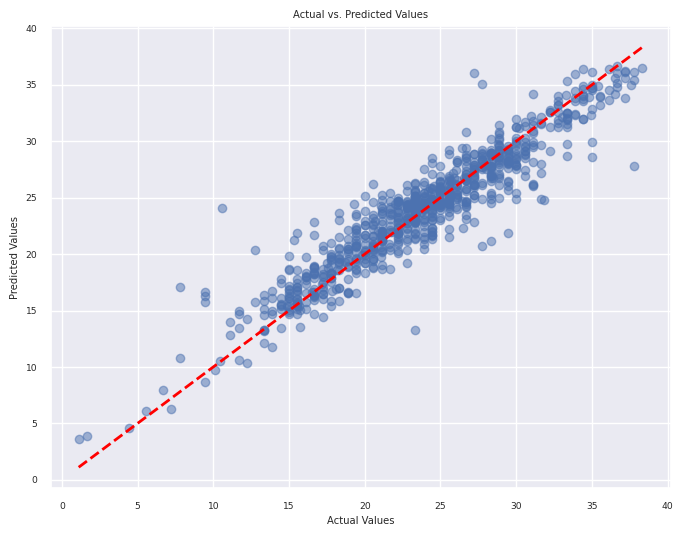

In [ ]:
# ran for too long, used best parameters from non-buffering run isntead

model_rf = RandomForestRegressor(n_estimators=512, max_features=None, max_depth=128, criterion='friedman_mse', random_state=42)
model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_test)

output_df = compute_metrics_and_plot('RandomForest', y_test, y_pred,"{'n_estimators': 512, 'max_features': None, 'max_depth': 128, 'criterion': 'friedman_mse'}", output_df)

In [ ]:
output_df.sort_values(by='R2', ascending=False)

,Model,Best Parameters,MAE,MSE,RMSE,R2
6,{XGBoost},"{'subsample': 0.75, 'min_child_weight': 2, 'ma...",1.295041,3.410538,1.846764,0.907125
7,{RandomForest},"{'n_estimators': 512, 'max_features': None, 'm...",1.506917,4.440128,2.107161,0.879087
5,{Decision Tree},"{'splitter': 'best', 'min_samples_split': 2, '...",1.930534,7.150556,2.674052,0.805277
4,{linear},-,2.235866,8.351322,2.889865,0.772578


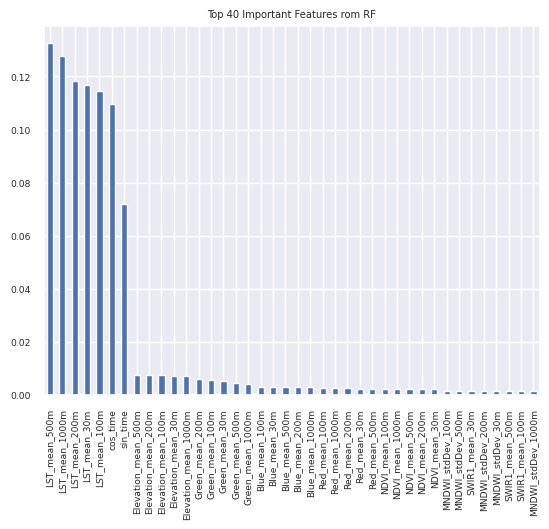

In [ ]:
# feature importance
forest_importances = pd.Series(model_rf.feature_importances_, index=X.columns)
std = np.std([tree.feature_importances_ for tree in model_rf.estimators_], axis=0)

forest_importances.sort_values(ascending=False)[:40].plot(kind='bar')
plt.title('Top 40 Important Features rom RF')
plt.xticks(rotation=90)
plt.show()

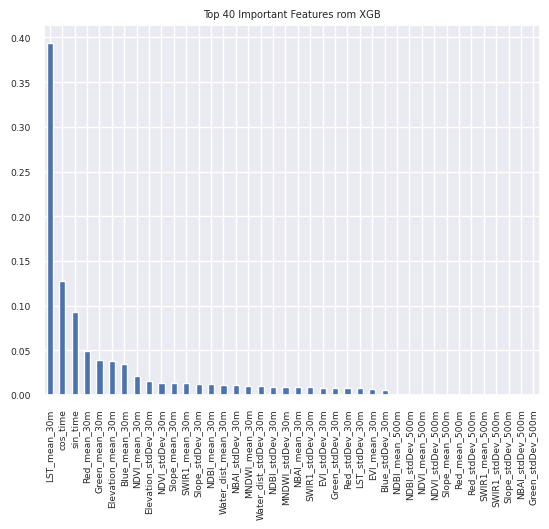

In [ ]:
xgb_importances = pd.Series(model_xgb.feature_importances_, index=X.columns)

xgb_importances.sort_values(ascending=False)[:40].plot(kind='bar')
plt.title('Top 40 Important Features rom XGB')
plt.xticks(rotation=90)
plt.show()

In [ ]:
def compute_metrics_feature_sizes(name, y_test, y_pred, params, output_df, k):
  '''
  runs evaluation metrics given predictions and true data, plots them, and appends values to array
  adapted to also include number of features
  '''
  # run evaluation metrics
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_test, y_pred)

  print(f'{name} MAE: {mae:.4f}')
  print(f'{name} MSE: {mse:.4f}')
  print(f'{name} RMSE: {rmse:.4f}')
  print(f'{name} R2: {r2:.4f}')

  # save values in df
  output_df.loc[len(output_df)] = [
        {name},
        params,
        k,
        mae,
        mse,
        rmse,
        r2
  ]

  return output_df

In [ ]:
# run regression mdoel training again for all models, with varying subset sizes of top ranking features
feature_sizes = [75, 50, 25]
results_list = []
output_df_feat = pd.DataFrame(columns=['Model', 'Best Parameters', 'Number of Features', 'MAE', 'MSE', 'RMSE', 'R2'])

models = {
    'Linear Regression': [model_linear],
    'Decision Tree': [model_dt, {'splitter': 'best', 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': None, 'max_depth': 8, 'criterion': 'squared_error'}],
    'XGBoost': [model_xgb, {'subsample': 0.75, 'min_child_weight': 2, 'max_depth': 6, 'gamma': 0, 'eta': 0.1}],
    'Random Forest': [model_rf, {'n_estimators': 512, 'max_features': None, 'max_depth': 128, 'criterion': 'friedman_mse'}]
}

for name in models:
  model = models[name][0]
  params = models[name][1] if len(models[name]) > 1 else None

  if name == 'Linear Regression':
      feature_importance = np.abs(model.coef_)
  elif name == 'Random Forest':
      feature_importance = model.feature_importances_ # running SHAP crashed multiple times
  else:
      explainer = shap.TreeExplainer(model)
      shap_values = explainer.shap_values(X_test)
      feature_importance = np.abs(shap_values).mean(axis=0)

  importance_series = pd.Series(feature_importance, index=X_train.columns)

  # loop through fetaure sets
  for k in feature_sizes:
    top_k_features = importance_series.nlargest(k).index.tolist()
    X_train_model = X_train[top_k_features]
    X_test_model = X_test[top_k_features]

    model.fit(X_train_model, y_train)
    y_pred = model.predict(X_test_model)

    output_df_feat = compute_metrics_feature_sizes(name, y_test, y_pred,params, output_df_feat, k)


Linear Regression MAE: 4.1867
Linear Regression MSE: 27.6375
Linear Regression RMSE: 5.2571
Linear Regression R2: 0.2474
Linear Regression MAE: 4.2953
Linear Regression MSE: 28.8561
Linear Regression RMSE: 5.3718
Linear Regression R2: 0.2142
Linear Regression MAE: 4.6954
Linear Regression MSE: 34.5545
Linear Regression RMSE: 5.8783
Linear Regression R2: 0.0590
Decision Tree MAE: 1.9246
Decision Tree MSE: 7.1281
Decision Tree RMSE: 2.6699
Decision Tree R2: 0.8059
Decision Tree MAE: 1.9236
Decision Tree MSE: 7.1349
Decision Tree RMSE: 2.6711
Decision Tree R2: 0.8057
Decision Tree MAE: 1.9259
Decision Tree MSE: 7.1070
Decision Tree RMSE: 2.6659
Decision Tree R2: 0.8065
XGBoost MAE: 1.3200
XGBoost MSE: 3.4825
XGBoost RMSE: 1.8662
XGBoost R2: 0.9052
XGBoost MAE: 1.3200
XGBoost MSE: 3.4825
XGBoost RMSE: 1.8662
XGBoost R2: 0.9052
XGBoost MAE: 1.2991
XGBoost MSE: 3.3786
XGBoost RMSE: 1.8381
XGBoost R2: 0.9080
Random Forest MAE: 1.5070
Random Forest MSE: 4.5046
Random Forest RMSE: 2.1224
Random

In [ ]:
output_df['Number of Features'] = 132
total_output_df = pd.concat([output_df, output_df_feat])
total_output_df.sort_values(by='R2', ascending=False)

,Model,Best Parameters,MAE,MSE,RMSE,R2,Number of Features
8,{XGBoost},"{'subsample': 0.75, 'min_child_weight': 2, 'ma...",1.299137,3.378582,1.838092,0.907995,25
6,{XGBoost},"{'subsample': 0.75, 'min_child_weight': 2, 'ma...",1.295041,3.410538,1.846764,0.907125,132
6,{XGBoost},"{'subsample': 0.75, 'min_child_weight': 2, 'ma...",1.319981,3.482543,1.866157,0.905164,75
7,{XGBoost},"{'subsample': 0.75, 'min_child_weight': 2, 'ma...",1.319981,3.482543,1.866157,0.905164,50
7,{RandomForest},"{'n_estimators': 512, 'max_features': None, 'm...",1.506917,4.440128,2.107161,0.879087,132
9,{Random Forest},"{'n_estimators': 512, 'max_features': None, 'm...",1.507008,4.504581,2.122400,0.877332,75
10,{Random Forest},"{'n_estimators': 512, 'max_features': None, 'm...",1.533593,4.643781,2.154943,0.873541,50
11,{Random Forest},"{'n_estimators': 512, 'max_features': None, 'm...",1.551858,4.679513,2.163218,0.872568,25
5,{Decision Tree},"{'splitter': 'best', 'min_samples_split': 2, '...",1.925941,7.106976,2.665891,0.806464,25
3,{Decision Tree},"{'splitter': 'best', 'min_samples_split': 2, '...",1.924559,7.128126,2.669855,0.805888,75


In [ ]:
total_output_df.to_csv('/content/drive/results_buffered_featuresize_2016.csv')

In [ ]:
model_xgb

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=2, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
print(model_xgb.feature_names_in_)

['LST_mean_30m' 'cos_time' 'sin_time' 'Elevation_mean_30m' 'Red_mean_30m'
 'Elevation_stdDev_30m' 'Blue_mean_30m' 'Water_dist_mean_30m'
 'NDVI_mean_30m' 'MNDWI_stdDev_30m' 'SWIR1_mean_30m' 'Green_mean_30m'
 'Slope_stdDev_30m' 'NDVI_stdDev_30m' 'Slope_mean_30m' 'Green_stdDev_30m'
 'SWIR1_stdDev_30m' 'MNDWI_mean_30m' 'NDBI_mean_30m'
 'Water_dist_stdDev_30m' 'NDBI_stdDev_30m' 'EVI_mean_30m' 'EVI_stdDev_30m'
 'NBAI_stdDev_30m' 'NBAI_mean_30m']


In [ ]:
####
# FOLLOWING CODE ORIGINATES FROM HANNA SWEDENKLEF (https://github.com/hannaswedenklef/SizzlingStockholm/blob/main/Script_4_ML_Regression.ipynb)
####

def get_shap_values(X_test, model):
    # Compute SHAP values on data
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    return shap_values

# Function to format labels for features in a more readable format
def format_label(label):
    parts = label.split('_')
    if len(parts) == 3:
        return f"{parts[1]}: {parts[0]}m ({parts[2]})"  # Format for buffer, variable, and stat (e.g., 'mean', 'std')
    elif len(parts) == 2:
        return f"{parts[1]}: {parts[0]}m"  # Format for buffer and variable
    else:
        return label  # Return the label as is if it's not in the expected format

# Function to plot SHAP summary for the top N features
def plot_shap_summary(shap_values, X_test, top_n=15):
    # Get the mean absolute SHAP values for each feature (feature importance)
    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    sorted_idx = np.argsort(mean_abs_shap)[::-1]  # Sort indices by descending SHAP importance
    top_columns = X_test.columns[sorted_idx[:top_n]]  # Select top N features

    # Normalize the selected features in X_test for coloring the plot
    scaler = MinMaxScaler()
    X_test_selected_normalized = pd.DataFrame(scaler.fit_transform(X_test[top_columns]), columns=top_columns)

    # Define the magnitude of jitter for adding variation to y-axis values
    jitter = 0.08

    # Create a plot figure with a primary axis (ax1)
    fig, ax1 = plt.subplots(figsize=(12, 8))
    fig.subplots_adjust(left=0.3)  # Adjust layout to leave space for y-axis labels

    # Plot SHAP values for each feature with jitter on the primary axis
    for i, col in enumerate(top_columns):
        y_jitter = (len(top_columns) - i - 1) + np.random.normal(loc=0, scale=jitter, size=len(shap_values))  # Add jitter to the y-axis
        if i == 0:
            ax1.scatter(0, 0, label=col, alpha=0)  # Dummy scatter for the first column to set the label
        else:
            ax1.scatter(shap_values[:, sorted_idx[i]], y_jitter, c=X_test_selected_normalized[col], label=col, alpha=0.5, cmap='viridis')

    # Set the y-axis labels with formatted feature names
    # y_labels = [format_label(col) for col in top_columns]
    y_labels = [col for col in top_columns]

    plt.yticks(range(len(top_columns)), y_labels[::-1])  # Reverse the labels to match the plot order

    # Add vertical and horizontal reference lines
    ax1.axvline(x=0, ymax=0.90, color='black', linestyle='--')  # Vertical line at x=0
    ax1.axhline(y=13.5, color='black', linestyle='-', linewidth=0.75)  # Horizontal line for separation

    # Set axis labels and title for the primary axis
    ax1.set_xlabel('SHAP Value (impact on model output), all other features')
    ax1.set_ylabel('Feature')
    ax1.set_title('SHAP Values for Most Important Features', fontsize=16, pad=16)

    # Create a secondary x-axis (ax2) for overlaying another set of plots
    ax2 = ax1.twiny()
    for i, col in enumerate(top_columns):
        y_jitter = (len(top_columns) - i - 1) + np.random.normal(loc=0, scale=jitter, size=len(shap_values))  # Add jitter for secondary axis
        if i != 0:
            ax2.scatter(0, 0, label=col, alpha=0)  # Dummy scatter for columns other than the first one
        else:
            ax2.scatter(shap_values[:, sorted_idx[i]], y_jitter, c=X_test_selected_normalized[col], label=col, alpha=0.5, cmap='viridis')

    # Add a vertical line on the secondary axis for visual alignment
    ax2.axvline(x=0, ymin=0.91, color='black', linestyle='--')

    # Label the secondary x-axis with a reference to the most important feature
    ax2.set_xlabel('SHAP Value (impact on model output), ' + format_label(top_columns[0]))

    # Combine the legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()

    # Add a color bar to show the range of feature values
    cb = plt.colorbar(lines2[0], ax=[ax1, ax2], location='right', pad=-0.05)
    cb.set_label('Feature Value')  # Label for the color bar
    cb.set_ticks([0, 1])  # Set the ticks at the extremes of the color scale
    cb.set_ticklabels(['Low', 'High'])  # Set labels for the ticks

    # Remove unnecessary spines from both axes
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)

    # Display the plot
    plt.show()

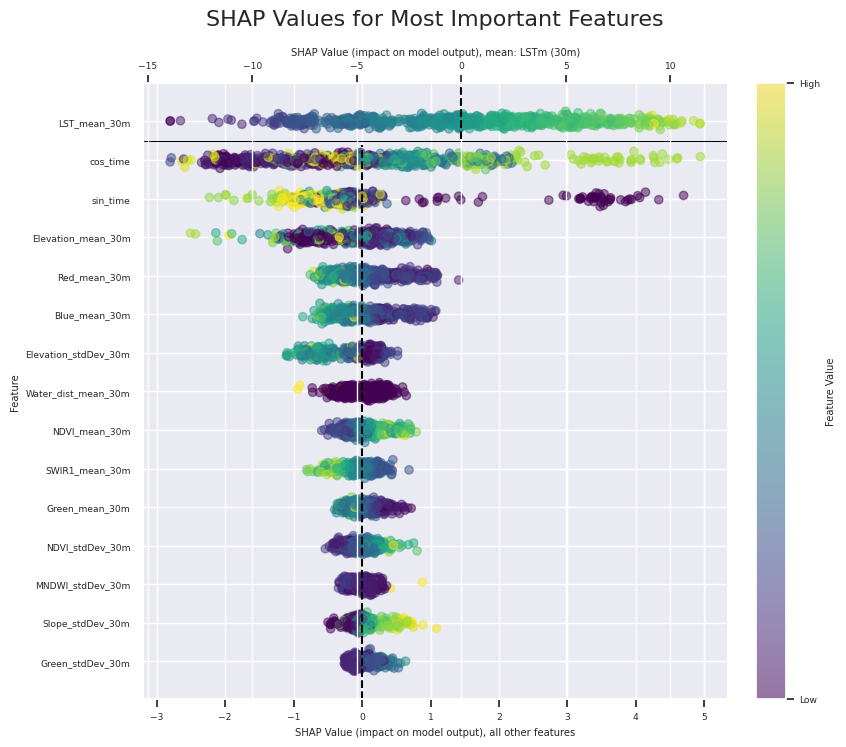

In [ ]:
shap_values = get_shap_values(X_test[model_xgb.feature_names_in_], model_xgb)
plot_shap_summary(shap_values, X_test[model_xgb.feature_names_in_])